In [1]:
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.signal import argrelextrema
import scipy as sp
import scipy.optimize as op
import matplotlib.pyplot as plt
from numba import njit,jit,vectorize,cfunc
import math
from numpy.random import default_rng, SeedSequence
from pydub import AudioSegment

In [2]:
rng = default_rng()

### Approximating n-dimensional differential equations

In [3]:
def rk4(fs,x0,h,numSteps):
    path = np.zeros((numSteps+1,x0.size))
    path[0] = x0
    def f(xt):
        return np.array(list(map(lambda fi: fi(xt),fs)))
    for i in trange(numSteps):
        k1 = (h/6)*f(x0)
        k2 = (h/6)*f(x0+(1/2)*k1)
        k3 = (h/6)*f(x0+(1/2)*k2)
        k4 = (h/6)*f(x0+k3)
        ks = k1+2*k2+2*k3+k4
        x1 = x0+(1/6)*ks
        path[i+1] = x1
        x0 = x1
    return path

We also need to allow for a version that can be driven by a signal

In [4]:
def drivenrk4(fs,x0,driver,signal,persample,h=None):
    if h == None:
        h = 1/persample
    s = sp.interpolate.interp1d(np.arange(signal.size),signal)
    numSteps = (signal.size-1)*persample
    xn = x0[driver]
    x0[driver] = s(0)
    x0 = np.append(x0,xn)
    path = np.zeros((signal.size,x0.size))
    path[0] = x0
    fn = fs[driver]
    fs[driver] = lambda x: 1
    fs = np.append(fs,fn)
    def f(xt):
        return np.array(list(map(lambda fi: fi(xt),fs)))
    j = 0
    for i in trange(numSteps):
        k1 = (h/6)*f(x0)
        k2 = (h/6)*f(x0+(1/2)*k1)
        k3 = (h/6)*f(x0+(1/2)*k2)
        k4 = (h/6)*f(x0+k3)
        ks = k1+2*k2+2*k3+k4
        x1 = x0+(1/6)*ks
        x1[driver] = s((i+1)/persample)
        if (i+1)%persample == 0:
            j += 1
            path[j] = x1
        x0 = x1
    return path

Allow for the signal to participate in the chaos

In [5]:
def semidrivenrk4(fs,x0,driver,signal,persample,h=None): #make sure signal is a function
    if h == None:
        h = 1/persample
    s = sp.interpolate.interp1d(np.arange(signal.size),signal)
    numSteps = (signal.size-1)*persample
    dim = x0.size+1
    x0 = np.append(x0,s(0))
    fs = np.append(fs,lambda x: 1)
    path = np.zeros((signal.size,x0.size))
    x0[driver] = x0[driver]
    path[0] = x0
    def f(xt):
        out = np.zeros_like(fs)
        for i,f in enumerate(fs):
            if i == driver:
                out[i] = f(xt)
                continue
            zs = np.zeros(dim)
            zs[driver] = xt[-1]
            out[i] = f(xt+zs)
        return out
    j = 0
    for i in trange(numSteps):
        k1 = (h/6)*f(x0)
        k2 = (h/6)*f(x0+(1/2)*k1)
        k3 = (h/6)*f(x0+(1/2)*k2)
        k4 = (h/6)*f(x0+k3)
        ks = k1+2*k2+2*k3+k4
        x1 = x0+(1/6)*ks
        x1[-1] = s((i+1)/persample)
        if (i+1)%persample == 0:
            j += 1
            path[j] = x1
        x0 = x1
    return path

### Some sample systems

In [6]:
def lorenz(s,r,b):
    fx = lambda x: s*(x[1]-x[0])
    fy = lambda x: r*x[0]-x[1]-x[0]*x[2]
    fz = lambda x: x[0]*x[1]-b*x[2]
    return np.array([fx,fy,fz])

In [7]:
def cuomoppenheim(s,r,b):
    fx = lambda x: s*(x[1]-x[0])
    fy = lambda x: r*x[0]-x[1]-20*x[0]*x[2]
    fz = lambda x: 5*x[0]*x[1]-b*x[2]
    return np.array([fx,fy,fz])

In [8]:
def rossler(a,b,c):
    fx = lambda x: -(x[1]+x[2])
    fy = lambda x: x[0]+a*x[1]
    fz = lambda x: b+x[2]*(x[0]-c)
    return np.array([fx,fy,fz])

In [3]:
def wuchua_transmitter(s,r,mu,b,signal,kind='cubic'):
    m = sp.interpolate.interp1d(signal,kind=kind)
    fx = lambda t,x: s*(x[1]-x[0])
    fy = lambda t,x: (r-mu)*(x[0]+m(t))+mu*x[0]-x[1]-(x[0]+m(t))*x[2]
    fz = lambda t,x: (x[0]+m(t))*x[1]-b*x[2]
    f = np.vectorize(lambda t,x: np.array([fx(t,x),fy(t,x),fz(t,x)]),signature='(),(3)->(3)')
    return f

In [4]:
def wuchua_reciever(s,r,mu,b,signal,kind='cubic'):
    m = sp.interpolate.interp1d(signal,kind=kind)
    fx = lambda t,x: s*(x[1]-x[0])
    fy = lambda t,x: (r-mu)*m(t)+mu*x[0]-x[1]-m(t)*x[2]
    fz = lambda t,x: m(t)*x[1]-b*x[2]
    f = np.vectorize(lambda t,x: np.array([fx(t,x),fy(t,x),fz(t,x)]),signature='(),(3)->(3)')
    return f

#### A random starting location

In [9]:
def randx(lowbound,highbound):
    off = lowbound
    ma = highbound-off
    offs = np.ones(3)*off
    return offs+(2*rng.random(size=3)-np.ones(3))*ma

Just to prove it works and because I've been working for 7+ hours so i need to sanity check it
i'm going to us the yz projections and we'll see how they line up

In [10]:
fs = cuomoppenheim(10,60,8/3)
steps = np.int_(1e2)
path0 = rk4(fs,randx(0.3,1),0.001,steps)
xs = path0[:,0]
path1 = drivenrk4(fs,randx(0.3,1),0,xs,1,h=0.001)
fig,(ax0,ax1) = plt.subplots(2,2,sharex='row', sharey='row')
ax0[0].set_title('Transmitter')
ax0[0].plot(*path0[:,[1,2]].T,',k')
ax0[0].set_xlabel('z')
ax0[0].set_ylabel('y')
ax0[1].set_title('Reciever')
ax0[1].set_xlabel('z')
ax0[1].plot(*path1[:,[1,2]].T,',k')
time = np.arange(steps+1)
ax1[0].set_xlabel('steps')
ax1[0].set_ylabel('x')
ax1[0].plot(time,path0[:,0])
ax1[1].set_xlabel('steps')
ax1[1].plot(time,path1[:,3])

### Encryption and decryption
First we generate the noise that we're interested in

In [11]:
def generate_mask(sample_rate,signal,fs,x0,persample):
    path = semidrivenrk4(fs,x0,0,signal,persample)
    xs = path[:,0]
    xs = xs/np.max(np.abs(xs))
    plt.plot(xs)
    plt.show()
    xs = np.float32(xs)
    mask = AudioSegment(
        xs.tobytes(),
        frame_rate=sample_rate,
        sample_width=xs.dtype.itemsize,
        channels=1
    )
    return mask

Then we add that to the signal we want to send (which has some silence before and after for the aforementioned borders)

In [12]:
#from pydub.playback import play
def encrypt(audio,fs,x0=randx(.3,1),preborder=500,postborder=0,persample=100):
    audio = audio.set_channels(1)
    rate = audio.frame_rate
    preborder = AudioSegment.silent(duration=preborder,frame_rate=rate)
    postborder = AudioSegment.silent(duration=postborder,frame_rate=rate)
    message = preborder + audio + postborder
    signal = np.array(message.get_array_of_samples())/2**(message.sample_width*8-1)
    plt.plot(signal)
    plt.show()
    mask = generate_mask(rate,signal,fs,x0,persample)
    return mask

Finally we pass that output through another sovler to get the data that we can subtract

In [13]:
def decrypt(signal,fs,driver,x0=randx(.3,1),persample=100):
    masked = np.array(signal.get_array_of_samples())/2**(signal.sample_width*8-1)
    rate = signal.frame_rate
    steps = masked.size
    path = drivenrk4(fs,x0,driver,masked,persample)
    urs = path[:,fs.size]
    plt.plot(urs)
    plt.show()
    message = np.float32(urs-masked)
    plt.plot(message)
    plt.show()
    out = AudioSegment(
        message.tobytes(),
        frame_rate=rate,
        sample_width=message.dtype.itemsize,
        channels=1
    )
    return out

## Let's try it!
using
On Hold For You by Kevin MacLeod

Link: https://incompetech.filmmusic.io/song/6928-on-hold-for-you

License: http://creativecommons.org/licenses/by/4.0/

(Be warned that the mask is *really* loud)

In [14]:
from IPython.display import Audio
jazz = AudioSegment.from_mp3("jazz.mp3")[:1000]
Audio("jazz.mp3")

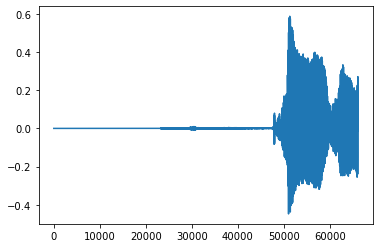

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.




KeyboardInterrupt



In [15]:
fs = cuomoppenheim(10,60,8/3)
lostjazz = encrypt(jazz,fs)
lostjazz.export("mjazz.wav",format='wav')
Audio("mjazz.wav")

In [ ]:
returnofthejazz = decrypt(lostjazz,fs,0)
returnofthejazz.export("djazz.wav",format='wav')
Audio("djazz.wav")